In [ ]:
pip install -q sbi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/IDM project")

%run IDM_helper_functions.ipynb

Mounted at /content/drive


In [ ]:
# Training data
n_sim_train = 1000000
prior_IDM_cpu = utils.BoxUniform(low=[0,0.2,0.1,0.01], high=[1,0.6,1,0.1]) # simulated data cannot be on gpu
param_IDM_cpu_train = prior_IDM_cpu.sample((n_sim_train,))

x_IDM_train = simul_IDM_EM4_D_bs700(np.array(param_IDM_cpu_train))

param_IDM_cpu_train = param_IDM_cpu_train[x_IDM_train[:,1]!=100] ## remove trials longer than 3s
x_IDM_train = x_IDM_train[x_IDM_train[:,1]!=100] ## remove trials longer than 3s

param_IDM_cpu_train = param_IDM_cpu_train[x_IDM_train[:,0]<3] ## remove trials longer than 3s
x_IDM_train = x_IDM_train[x_IDM_train[:,0]<3] ## remove trials longer than 3s

prior_IDM = utils.BoxUniform(low=[0,0.2,0.1,0.01], high=[1,0.6,1,0.1], device = "cuda")


In [ ]:
from sbi.inference import MNLE
from sbi.utils import likelihood_nn
# build mnle net
neural_net = likelihood_nn(model="mnle",
  num_transforms=5,  # number of transforms in the neural spline flow (the more the more expressive, but slower) 2
  num_bins = 10,  # number of bins for the splines (the more the more expressive, but slower) 5
  hidden_features = 200,  # number of hidden units for the Categorical net and the Spline Flow) 50
  hidden_layers = 5,  # number of hidden layers 2
  tail_bound = 10.0,  # upper and lower bound for neural splines
  log_transform_x = True,  # whether to log-transform the reaction times to make them unbounded.
                          )


In [ ]:
# Train MNLE and obtain MCMC-based posterior.

trainer = MNLE(prior=prior_IDM, density_estimator=neural_net, device = "cuda")
trainer = trainer.append_simulations(param_IDM_cpu_train, x_IDM_train)
mnle = trainer.train(training_batch_size = 1000, discard_prior_samples = True, show_train_summary = True)


/content/drive/MyDrive/IDM project/sbi/utils/user_input_checks.py:711: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(
/content/drive/MyDrive/IDM project/sbi/utils/user_input_checks.py:719: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda:0'.Training will proceed on device 'cuda:0'.
  warnings.warn(
/content/drive/MyDrive/IDM project/sbi/neural_nets/mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: 1.2967
        -------------------------
        


In [ ]:
torch.save(trainer, "/content/drive/MyDrive/IDM project/IDM_EM4_D_bs700_corrected")
#trainer = torch.load("IDM_EM4_D_bs700_corrected")

/content/drive/MyDrive/IDM project/sbi/inference/base.py:429: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  warn(


## Cross-fitting between DDM and IDM

In [ ]:
n_trials = 1000
sim_num = 100

prior_DDM_cpu = utils.BoxUniform(low=[0,0.5,0.2], high=[4,2,0.5]) # simulated data cannot be on gpu
param_DDM_cpu = prior_DDM_cpu.sample((sim_num,))
prior_IDM = utils.BoxUniform(low=[0,0.2,0.1,0.01], high=[1,0.6,1,0.1], device = "cuda")

par_fitted = np.zeros((sim_num,4))

/content/drive/MyDrive/IDM project/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [ ]:
for i in range(sim_num):
    print(i)
    IDM_o = simul_DDM(np.tile(param_DDM_cpu[i,:], (n_trials,1))) #
    IDM_o = IDM_o[IDM_o[:,1]!=100] ## remove trials longer than 3s
    IDM_o = IDM_o[IDM_o[:,0]<3] ## remove trials longer than 3s
    print(IDM_o.shape)
    mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
    mnle_posterior = trainer.build_posterior(prior = prior_IDM,
                                             mcmc_method="slice_np_vectorized",
                                             mcmc_parameters=mcmc_parameters)

    mnle_posterior.set_default_x(IDM_o)
    mnle_map = mnle_posterior.map()
    print(param_DDM_cpu[i,:])
    print(mnle_map)
    par_fitted[i,:] = np.array(mnle_map.cpu())

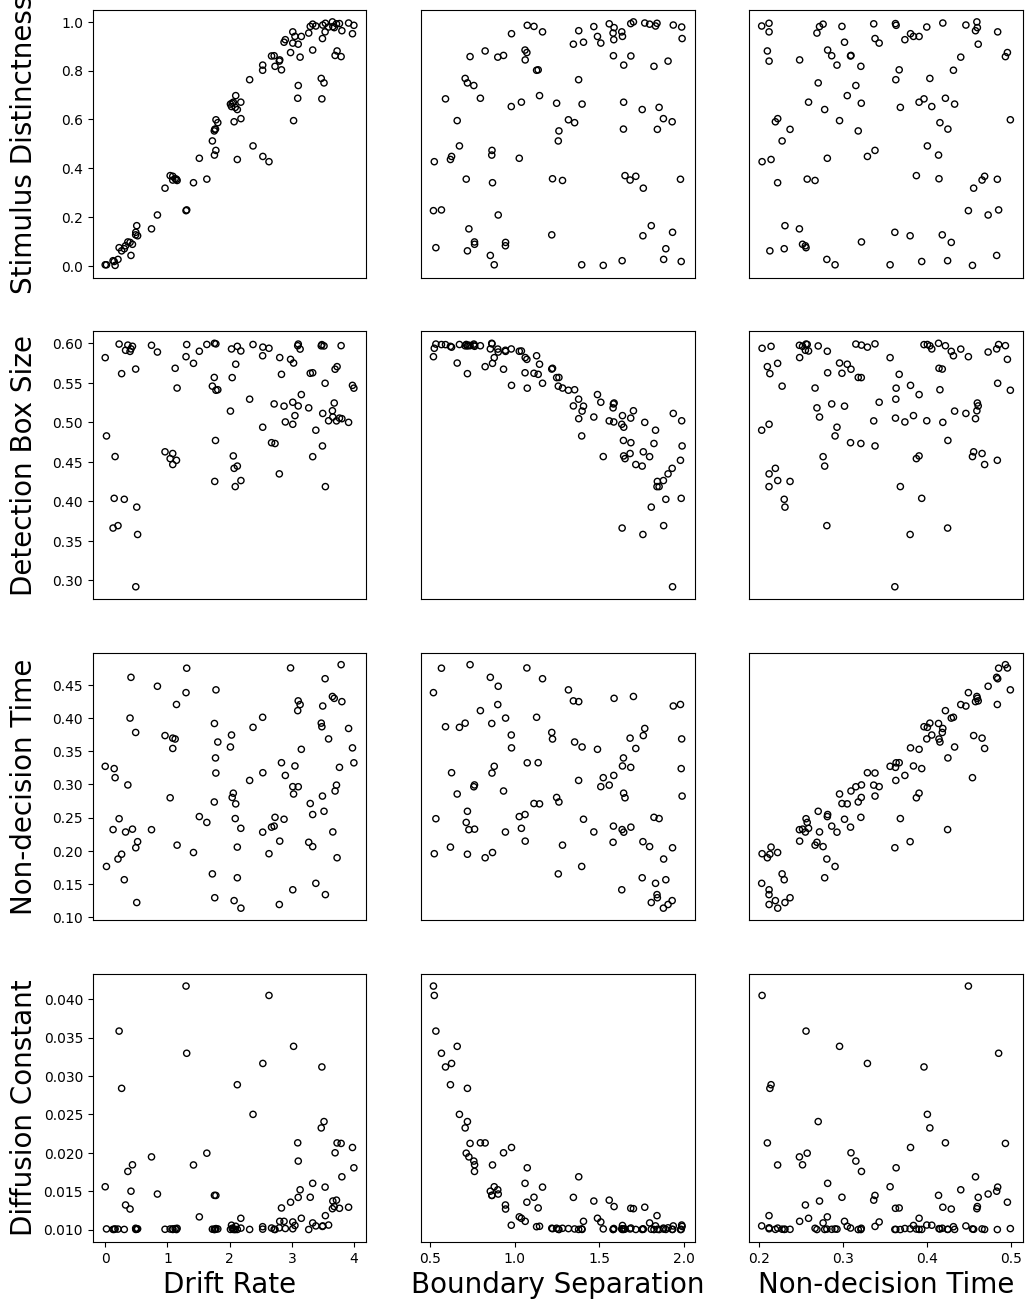

In [ ]:
par_labels = ["Drift Rate", "Boundary Separation", "Non-decision Time"]
par_fitted_labels = ["Stimulus Distinctness", "Detection Box Size", "Non-decision Time", "Diffusion Constant"]
sim_fit_plot_all(param_DDM_cpu, par_fitted, par_labels, par_fitted_labels, fontsize=20, s = 20, figsize=(12,16))

# Parameter recovery of IDM

In [ ]:
n_trials = 1000
sim_num = 100
#param_IDM_cpu = prior_IDM_cpu.sample((sim_num,))
par_fitted = np.zeros((sim_num,4))
prior_IDM_cpu = utils.BoxUniform(low=[0,0.2,0.1,0.01], high=[1,0.6,1,0.1]) # simulated data cannot be on gpu
param_IDM_cpu = prior_IDM_cpu.sample((sim_num,))

prior_IDM = utils.BoxUniform(low=[0,0.2,0.1,0.01], high=[1,0.6,1,0.1], device = "cuda")


/content/drive/MyDrive/IDM project/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [ ]:
for i in range(sim_num):
    print(i)
    IDM_o = simul_IDM_EM4_D_bs700(np.tile(param_IDM_cpu[i,:], (n_trials,1))) #
    IDM_o = IDM_o[IDM_o[:,1]!=100] ## remove trials longer than 3s
    IDM_o = IDM_o[IDM_o[:,0]<3] ## remove trials longer than 3s

    mcmc_parameters = dict(num_chains=50,thin=10,warmup_steps=50,init_strategy="proposal")
    mnle_posterior = trainer.build_posterior(prior = prior_IDM,
                                             mcmc_method="slice_np_vectorized",
                                             mcmc_parameters=mcmc_parameters)

    mnle_posterior.set_default_x(IDM_o)
    mnle_map = mnle_posterior.map()
    print(param_IDM_cpu[i,:])
    print(mnle_map)
    par_fitted[i,:] = np.array(mnle_map.cpu())

0
sim0


/content/drive/MyDrive/IDM project/sbi/utils/sbiutils.py:316: UserWarning: An x with a batch size of 1000 was passed. It will be interpreted as a batch of independent and identically
            distributed data X={x_1, ..., x_n}, i.e., data generated based on the
            same underlying (unknown) parameter. The resulting posterior will be with
            respect to entire batch, i.e,. p(theta | X).
  warnings.warn(


tensor([0.0175, 0.5001, 0.5314, 0.0230])
tensor([1.7210e-05, 4.0661e-01, 5.0619e-01, 2.5803e-02], device='cuda:0')
1
sim0
tensor([0.7222, 0.4473, 0.9938, 0.0639])
tensor([0.6796, 0.3419, 0.9844, 0.0684], device='cuda:0')
2
sim0
tensor([0.8884, 0.4441, 0.3425, 0.0163])
tensor([0.8385, 0.4408, 0.3454, 0.0174], device='cuda:0')
3
sim0
tensor([0.1633, 0.2454, 0.6279, 0.0888])
tensor([0.2027, 0.3691, 0.6422, 0.0879], device='cuda:0')
4
sim0
tensor([0.3771, 0.2333, 0.9178, 0.0676])
tensor([0.3848, 0.2489, 0.9188, 0.0656], device='cuda:0')
5
sim0
tensor([0.2079, 0.4288, 0.7523, 0.0975])
tensor([0.1961, 0.4340, 0.7527, 0.0984], device='cuda:0')
6
sim0
tensor([0.3601, 0.5852, 0.1563, 0.0944])
tensor([0.3634, 0.5901, 0.1601, 0.1000], device='cuda:0')
7
sim0
tensor([0.5936, 0.3123, 0.9669, 0.0805])
tensor([0.5411, 0.2439, 0.9677, 0.0936], device='cuda:0')
8
sim0
tensor([0.2257, 0.5479, 0.5470, 0.0641])
tensor([0.3277, 0.5999, 0.5499, 0.0392], device='cuda:0')
9
sim0
tensor([0.3031, 0.2983, 0.2882

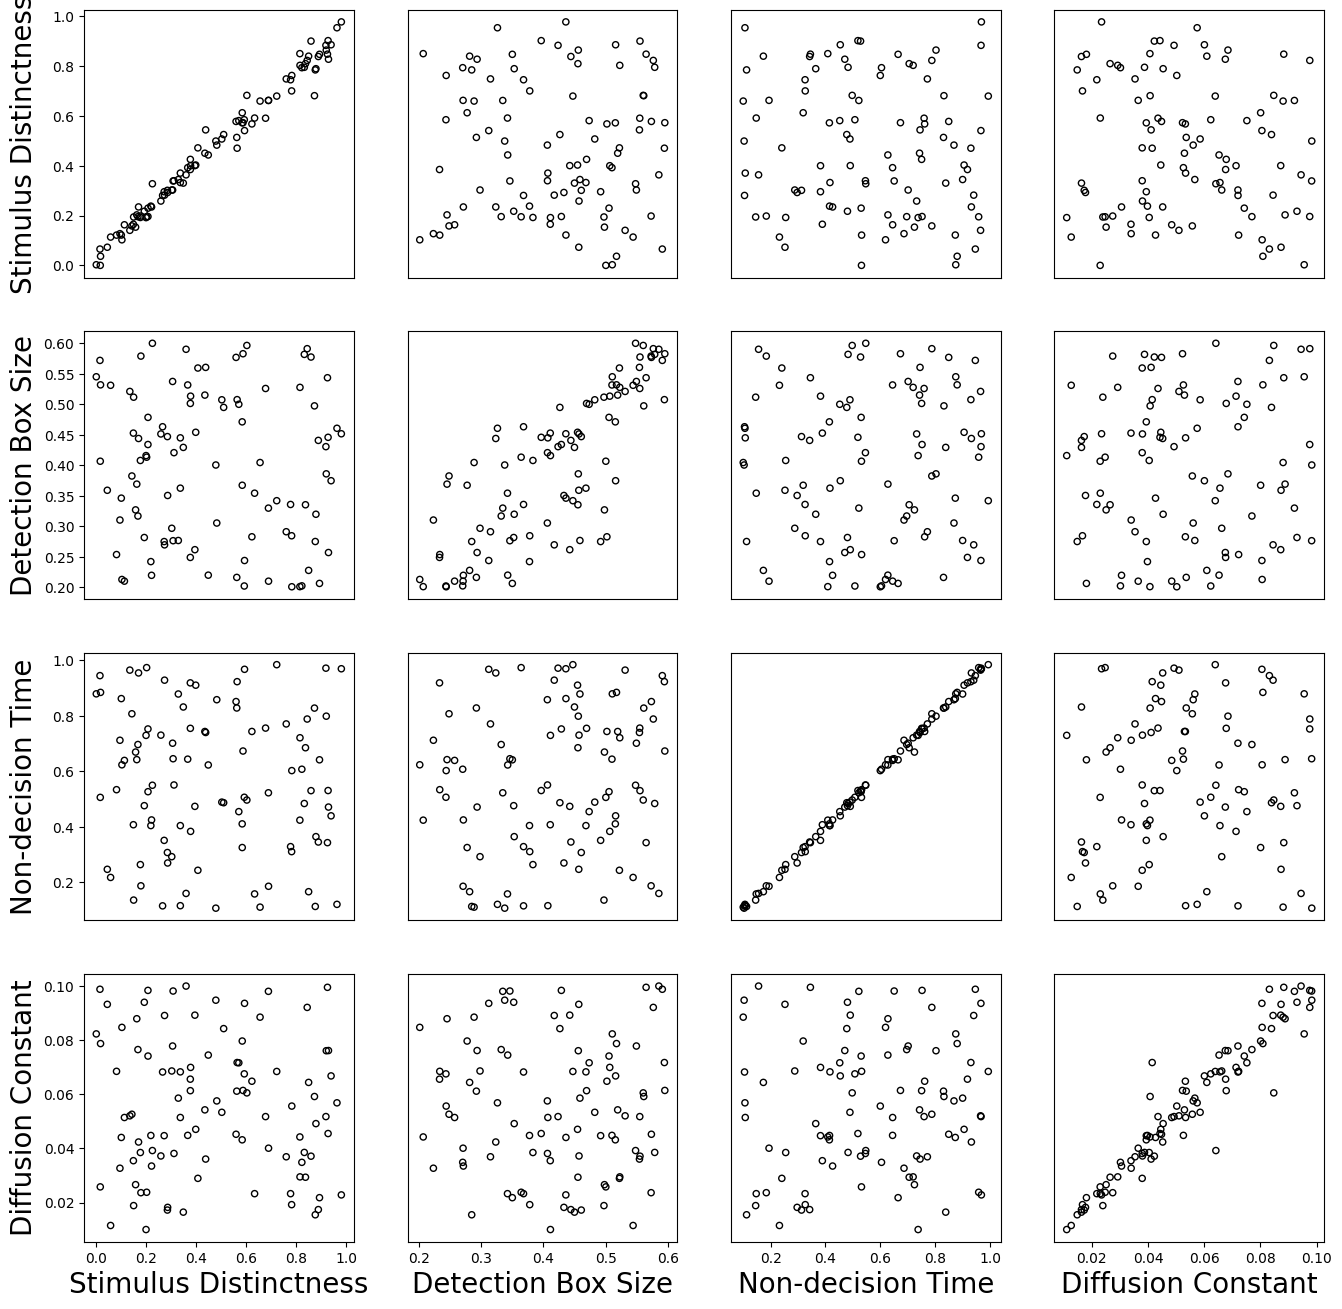

In [ ]:
par_labels = ["Stimulus Distinctness", "Detection Box Size", "Non-decision Time", "Diffusion Constant"]
par_fitted_labels = ["Stimulus Distinctness", "Detection Box Size", "Non-decision Time", "Diffusion Constant"]
sim_fit_plot_all(param_IDM_cpu, par_fitted, par_labels, par_fitted_labels, fontsize = 20, s = 20, figsize=(16,16))